# NLP_GoingDeeper | 8. Seq2seq으로 번역기 만들기
===

Seq2seq 기반 번역기를 직접 만들어보며 구조를 이해해 본다. Attention 기법을 추가하여 성능을 높여볼 수 있다. 영어-스페인어 말뭉치와 한국어-영어 말뭉치를 활용해 본다.

[학습 목차]
- 8-2. 데이터 전처리
- 8-3. 모델 설계
- 8-4. 훈련하기 (1) Optimizer & Loss
- 8-5. 훈련하기 (2) train_step 구현하기
- 8-6. 훈련하기 (3) 훈련 시작하기

NLP Going Deeper 이전 노드에서 살펴본 seq2seq를 활용해서 번역기를 만드는 프로젝트를 수행합니다.

**seq2seq는 2개의 RNN 모듈을 Encoder-Decoder 구조로 결합한 모델입니다.**

우선 아래와 같이 디렉토리를 만든 후, 한국어를 잘 시각화하고 올바른 Attention Map을 확인할 수 있도록 한국어를 지원하는 폰트로 바꾸어 줍니다.

아래 명령어의 **첫 줄은 디렉토리를 생성해주며, 두 번째 줄은 나눔 글꼴을 설치**해주는 명령어입니다. 😉😉

참고로 설치된 글꼴이 작업 과정에서 잘 보이기 위해서 LMS 시스템을 재구동시키는 작업이 권장됩니다!

In [1]:
# 항상 하는 미친짓 ^^ 
import time
start_time = time.time()

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = 'C:/Users/Noah/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


# 8-2. 데이터 전처리

## 데이터 준비하기

먼저 프로젝트에 사용될 라이브러리를 import 하도록 합시다.

In [3]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.8.0


한편, 텐서플로우에서는 **tf.keras.utils.get_file()** 이라는 메서드가 있습니다.

get_file() 은 URL로부터 데이터를 다운로드 받을 수 있게 하고, 압축된 형식이라면 압축 해제까지 수행해 주는 스마트한 함수입니다!

해당 메서드를 활용하여 데이터를 다운로드 해봅시다. 😎

데이터를 다운로드하는 데에는 텐서플로우에서 제공하는 tf.keras.utils.get_file() 함수를 사용할 겁니다. get_file()함수는 URL로부터 데이터를 다운받고, 압축된 형식일 경우 해제까지 알아서 할 수 있는 똑똑한 함수랍니다! 아래 소스를 실행해 데이터를 다운로드받아주세요.

In [4]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

- tf.keras.utils.get_file : Downloads a file from a URL if it not already in the cache    
    https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file

In [5]:
with open(path_to_file, "r" , encoding='utf8') as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


## 데이터 전처리: 정제하기

데이터는 \t 기호를 기준으로 영어와 스페인어가 병렬 쌍을 이루고 있습니다. 고로 \t 기호를 매개변수로 split() 함수를 호출하면 손쉽게 소스 문장과 타겟 문장을 분리할 수 있겠죠! 추가로 위 예시의 네 번째 문장을 보면 ¡ 같은 요상한 기호가 포함되어 있곤 합니다. 이 같은 특수문자는 불필요한 노이즈로 작용할 수 있기 때문에 정제 과정에서 삭제하도록 하겠습니다.

- 참고 : 사실 스페인에서는 역 물음표(¿)와 역 느낌표(¡)를 일반적으로 사용합니다. 문장이 물음표나 느낌표로 끝난다면 해당 문장 맨 앞에 역으로 된 기호를 붙여준다고 해요.    

정제는 아래 소스를 실행함으로써 진행할 수 있습니다.

In [6]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

전처리 과정에서 문장의 시작 문자 <start>, 종료 문자 <end> 를 붙여주게 됩니다. 이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 됩니다. 이전 렉처 노드에서 살펴보았듯, Decoder는 첫 입력으로 사용할 시작 토큰과 문장생성 종료를 알리는 끝 토큰이 반드시 필요하기 때문입니다.
    
원활한 학습을 위해 데이터는 상위 3만 개만 사용하도록 하겠습니다.

In [7]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


## 데이터 전처리: 토큰화

정제된 텍스트를 아래 tokenize() 함수를 사용해 토큰화하고 텐서로 변환합니다. 그리고 변환된 텐서를 80%의 훈련 데이터와 20%의 검증 데이터로 분리합니다. (Tokenizer의 단어 수는 자유롭게 진행)

In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [9]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4931
Spanish Vocab Size: 8893


# 8-3. 모델 설계

이제부터 아래 그림처럼 각각 1개의 GRU을 갖는 Encoder-Decoder 구조를 설계할 겁니다.

- GRU (Gate Recurrent Unit) : https://wikidocs.net/22889

[GRU 구조]
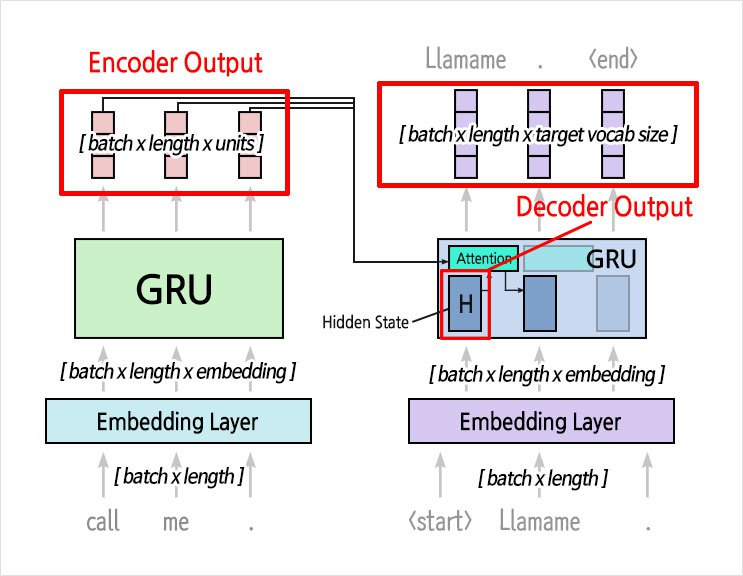

Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어 냅니다.
    
Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.
    
여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.
    
Attention은 Bahdanau을 사용할 예정이며, 이는 이전 렉처 노드에서 실습한 코드를 가져다가 쓰도록 할게요.

- Score_alignment = W_combine × tanh(W_decoder × H_decoder + W_encoder × H_encoder)

In [10]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

- tf.reduce_sum : Computes the sum of elements across dimensions of a tensor   
    https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum
    
위 그림과 동일한 구조를 갖는 Encoder 클래스와 Decoder 클래스를 설계합니다. 

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

- tf.keras.layers.GRU    
    return_sequences : return the last output in the output sequence, or the full sequence     
    return_state : return the last state in addition to the output    
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [13]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

In [14]:
# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len)) # (64, 30)
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units)) # (64, 1024)

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 8894)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


# 8-4. 훈련하기 (1) Optimizer & Loss

지금까지는 fit() 함수로 간편하게 학습을 진행했지만, Encoder-Decoder 구조의 경우 입출력이 단순하지 않아 학습 과정을 직접 정의해줘야 합니다. 

## Optimizer & Loss


In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

- tf.keras.losses.SparseCategoricalCrossentropy : Computes the crossentropy loss between the labels and predictions    
    from_logits	: Whether y_pred is expected to be a logits tensor    
    reduction : If reduction is NONE, this has shape [batch_size, d0, .. dN-1]     
    https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy    
- tf.math.equal(x, y) : Returns the truth value of (x == y) element-wise    
    https://www.tensorflow.org/api_docs/python/tf/math/equal
- tf.math.logical_not(x) : Returns the truth value of NOT x element-wise    
    https://www.tensorflow.org/api_docs/python/tf/math/logical_not    
- tf.cast(x, dtype) : Casts a tensor to a new type    
    https://www.tensorflow.org/api_docs/python/tf/cast?hl=ko    
- tf.reduce_mean : Computes the mean of elements across dimensions of a tensor    
    https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean

Optimizer는 모델이 학습할 때에 정답을 찾아가는 방법 정도로 설명할 수 있는데, 일반적으론 Adam 외의 것을 사용하지 않으니 후에 실력이 더 늘어나고 나서 공부하시는 것을 권장합니다!     
    
여기서 fit() 함수를 사용할 수 없는 이유는 바로 **Loss** 함수 때문입니다. 앞서 설명한 것처럼 Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 **직접 Loss를 커스텀**해서 사용해야 하기 때문이죠.
    
SparseCategoricalCrossentropy() 함수는 **모델이 출력한 확률 분포**와 (One-hot이 아닌) **정수 인덱스 답안**을 비교해 Cross Entropy값을 구해줍니다. CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 거죠. from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정합니다. 우리는 True 로 줬으니 **모델의 출력값을 그대로 전달**하면 됩니다!
    
데이터를 한 번에 처리하기 위해 가장 긴 문장을 기준으로 **패딩(Padding)** 과정을 거친 것을 기억하나요? tokenize() 함수 내부의 pad_sequences() 가 바로 그 역할을 해주는 녀석이었죠!
    
만약 모델에게 \<PAD> 토큰이 **패딩을 위한 토큰이라고 명시하지 않으면** 모델은 데이터의 굉장히 많은 부분이 \<PAD> 로 이뤄져 있다고 생각하게 됩니다. 쉽게 말해 유난히 같은 답이 많은 객관식 시험이라고나 할까요...? 어떤 시험이 한 번호로만 찍어도 80점 이상을 받을 수 있다면 그 시험은 공부를 절대 하지 않겠죠! 모델은 심지어 10,000개의 정답이 넘게 있는 고난도의 문제를 풀고 있기 때문에 **패딩에 대한 처리**를 해주지 않으면 \<PAD> 토큰만을 생성할 확률이 굉장히 높아집니다.
    
이것은 종종 발생하는 문제라서 기억해두시면 좋아요. 이 문제를 방지하기 위해 mask 가 사용됩니다! mask 는 정답지에서 \<PAD> 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 해주죠. equal() 함수에 정확히는 0 이 아닌 \<PAD> 토큰의 인덱스를 전달하는 것이 맞지만 **대부분의 경우는 0으로 패딩**되기 때문에 편의상 0을 전달하여 처리하도록 하겠습니다.



# 8-5. 훈련하기 (2) train_step 구현하기

train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수입니다. 


In [16]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src) # context vec
        h_dec = enc_out[:, -1] # t=0 : enc_final_state
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1) # 정답을 다음 입력으로 
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

- @tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다. 첫 번째 Epoch이 다른 Epoch보다 약간의 시간이 더 걸리는 것은 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문이죠! 실제로 위 예제에서 @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간이 소요된답니다! 그러니 가능하다면 사용하는 쪽이 유리하겠죠? 
    - @tf.function의 공식 문서 : https://www.tensorflow.org/guide/function?hl=ko    
- tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 테이프입니다. 이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됩니다.    
    - tf.GradientTape() : https://www.tensorflow.org/guide/autodiff?hl=ko    
- tf.compat.v1.trainable_variables : Returns all variables created with trainable=True    
    https://www.tensorflow.org/api_docs/python/tf/compat/v1/trainable_variables
- tape.gradient() : Computes the gradient using operations recorded in context of this tape         
    https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient
- optimizer.apply_gradients : Apply gradients to variables    
    https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
    
    
train_step()의 학습 과정은 아래와 같습니다.

1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]
3. Decoder에 입력으로 전달할 \<start> 토큰 문장 생성
4. \<start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
6. 반복!

# 8-6. 훈련하기 (3) 훈련 시작하기

In [17]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|█████████████████████████████████████████████████████████| 375/375 [00:23<00:00, 15.70it/s, Loss 0.1401]


- tqdm은 훈련의 진행 과정을 한눈에 볼 수 있게 해주는 라이브러리입니다. 사용법은 위 예제만 봐도 이해가 갈 정도로 정말 간단하니 웬만하면 활용하시는 것을 추천해 드려요! # tqdm이 붙은 라인은 모두 출력에 관련된 내용이니 설명을 생략하겠습니다.    
    tqdm/tqdm : https://github.com/tqdm/tqdm
- EPOCHS = 10 만큼 반복하는 루프에 진입한 후, 각 배치의 시작 인덱스를 idx_list 배열에 저장합니다. 그리고 모델이 학습을 원활하게 할 수 있도록 데이터를 섞어줘야 하는데요, 인덱스를 섞어서 처리할 겁니다. 순차적인 인덱스로 데이터를 불러오는 게 아닌 랜덤한 인덱스로 데이터를 불러오는 것은 데이터를 섞는 것과 동일한 효과를 가져오겠죠!   
- 그 후에 각 미니배치를 train_step() 함수에서 학습합니다. train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수입니다. 

## 실습하기

Step 1에서 분리한 Validation Set을 사용하는 eval_step() 함수를 정의합니다. 그리고 train_step() 을 마친 후, 곧이어 eval_step() 을 진행하도록 소스를 수정합니다. 

In [18]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [19]:
# Training Process : train_step() 이후 eval_step() 진행

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    
    # train step 
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    # eval step
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|█████████████████████████████████████████████████| 94/94 [00:02<00:00, 39.47it/s, Test Loss 0.7526]


훈련이 완료된 모델은 아래 소스를 실행해 번역 성능을 평가할 수 있어요. Attention Map을 시각화하는 것는 보너스!

In [20]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [21]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

- [matplotlib.axes.Axes.matshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.matshow.html) :     
    Plot the values of a 2D matrix or array as color-coded image    
- [matplotlib.axes.Axes.set_xticklabels](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html) :     
    Set the xaxis' labels with list of string labels    
- [matplotlib.ticker.MultipleLocator](https://matplotlib.org/stable/api/ticker_api.html#matplotlib.ticker.MultipleLocator) :     
    Set a tick on each integer multiple of a base within the view interval    
- [matplotlib.axis.XAxis.set_major_locator](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.axis.XAxis.set_major_locator.html) :     
    Set the locator of the major ticker    
 

In [22]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

C:\Users\Noah\AppData\Local\Temp\ipykernel_34584\421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Noah\AppData\Local\Temp\ipykernel_34584\421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


Input: can i have some coffee ?
Predicted translation: me das a algo de caf ? <end> 


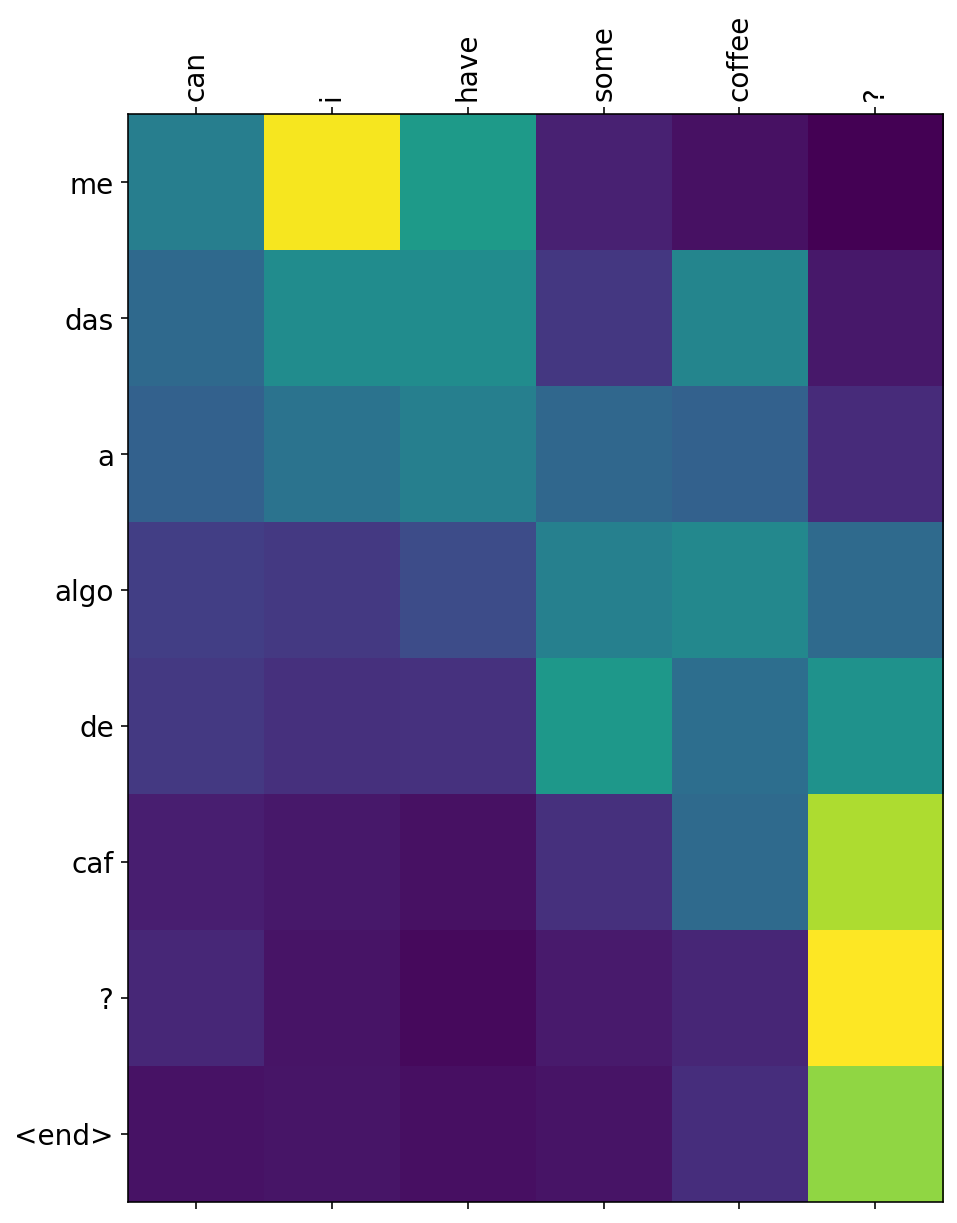

In [23]:
translate("Can I have some coffee?", encoder, decoder)

Input: did you eat lunch ?
Predicted translation: yo caus eso ? <end> 


C:\Users\Noah\AppData\Local\Temp\ipykernel_34584\421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Noah\AppData\Local\Temp\ipykernel_34584\421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


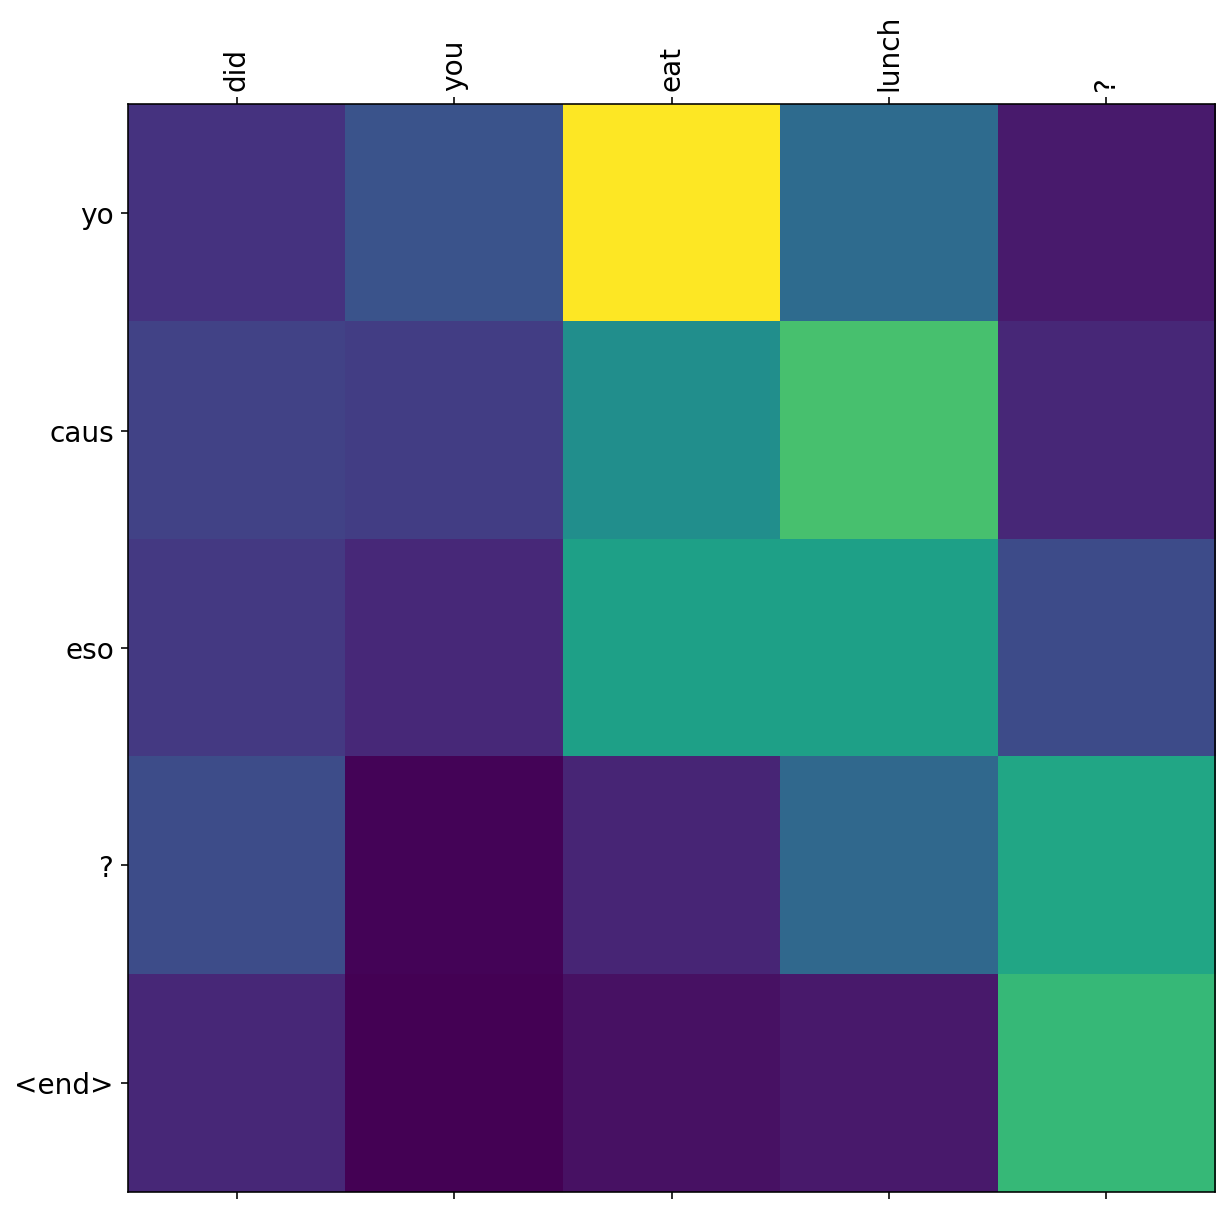

In [24]:
translate("Did you eat lunch ?", encoder, decoder)

Input: i love you ! !
Predicted translation: te quiero ! <end> 


C:\Users\Noah\AppData\Local\Temp\ipykernel_34584\421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Noah\AppData\Local\Temp\ipykernel_34584\421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


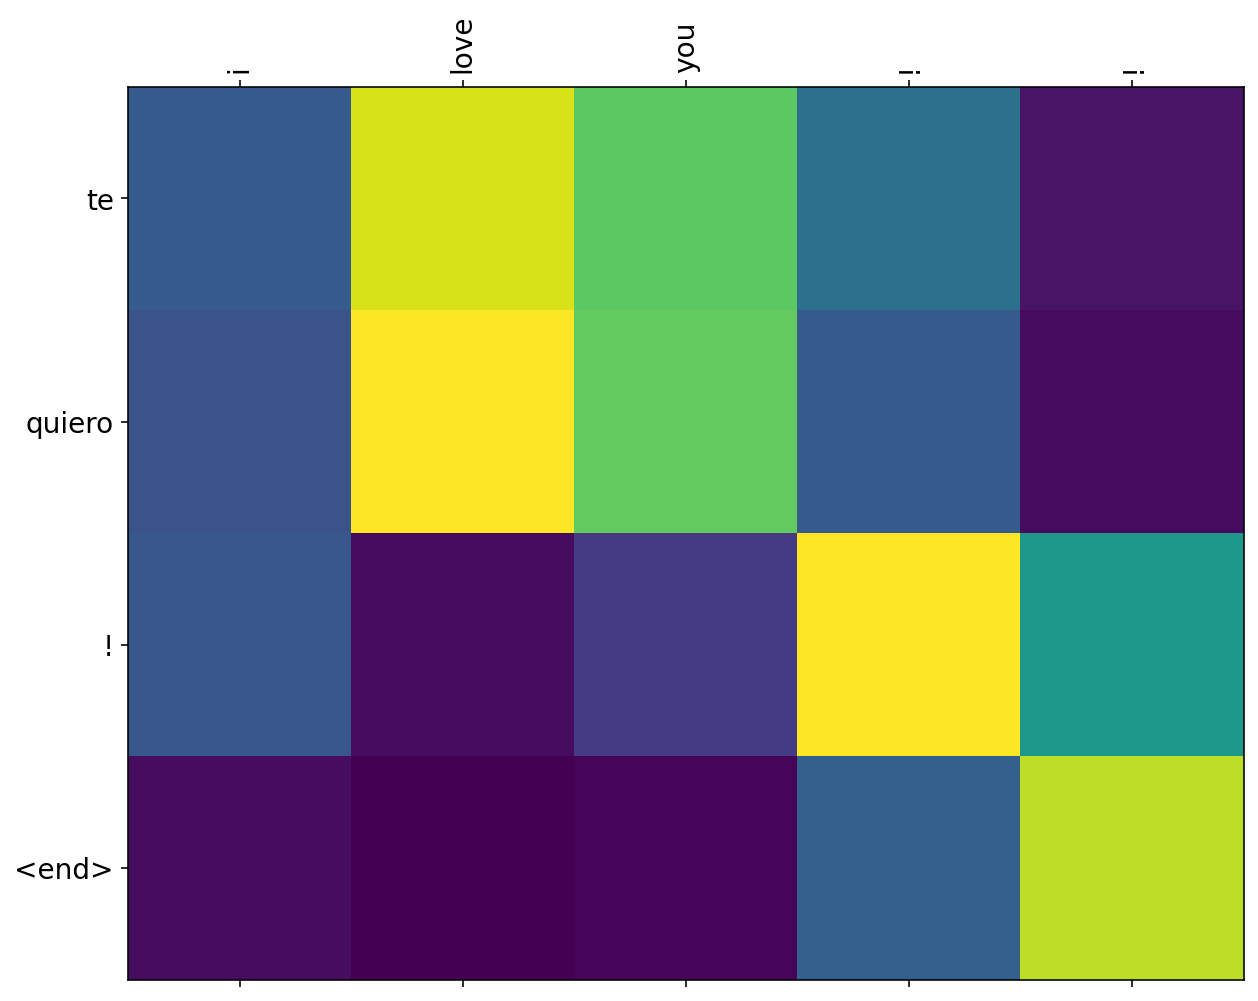

In [25]:
translate("I love you !!", encoder, decoder)

In [26]:
end_time = time.time()
work_time = round(end_time - start_time)
print(f'총 작업 소요 시간은 약 {work_time}초입니다.')

총 작업 소요 시간은 약 539초입니다.
